# CART - Classification and Regression Trees

Tasniflendirme ve regresyon agaclari temel olarak ust uste koyulmus if-else kosullarindan olusan binary agaclardir. Yapilarindan oturu, tasniflendirme ve regresyon agaclari ust duzey aciklanabilirlik saglarlar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from termcolor import cprint
from IPython.display import display, Markdown

## 1. Metrikler

Karar agaclari, her bir dugum noktasinda en iyi bolumlendirmeyi belirlemek icin bir olcume ihtiyac duyarlar. En iyi bolumlendirme:
- Tasniflendirme icin
    - en dusuk entropi,
    - ya da en dusuk safsizlik,
- Regresyon icin
    - en dusuk varyans,
    - en dusuk MAE,
    - ya da en yuksek korelasyonu

saglayan bolumlendirme olabilir.

### 1.a Tasniflendirme

Agac olusturucu, her dugum noktasinda verilen stratejiye gore en iyi bolumlendirmeyi belirler. Bu strateji **Gini Impurity** ya da  **Entropi** olabilir.

#### 1.a.I Gini Impurity (Safsizlik)

Gini safsizlik indeksi, kategorik degiskenlerden olusan bir veri setinin safligini belirten bir metriktir.

$$Gini\ Impurity=1 - \sum_i{p_i^2}$$

In [2]:
eps = 1e-10
p = np.linspace(eps, 1. - eps, 1000)

In [3]:
def gini_impurity(p):
    """Ikili tasnfilendirme islemi icin gini safsizlik degerini hesaplar"""
    return 1. - p**2 - (1 - p)**2

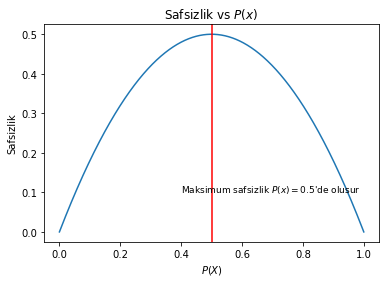

In [4]:
plt.plot(p, gini_impurity(p))
plt.axvline(0.5, color='r')
plt.text(0.4, 0.1, "Maksimum safsizlik $P(x)=0.5$'de olusur", size=9)
plt.xlabel('$P(X)$')
plt.ylabel('Safsizlik')
_ = plt.title('Safsizlik vs $P(x)$')

#### 1.a.II Entropi

Kelime anlami itibariyle **duzensizlik** demek olan entropi, safsizligin bir olcumu olarak kullanilabilir.

$$Entropy=-\sum_i{p_i log(p_i)}$$

In [5]:
def entropy(p):
    """Ikili tasniflendirme islemi icin entropi degerini hesaplar"""
    return -(p * np.log(p) + (1 - p) * np.log(1 - p))

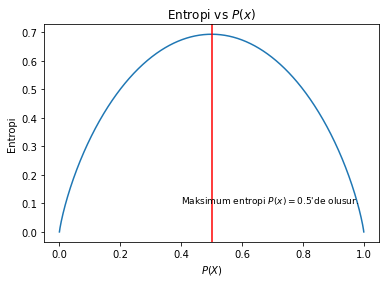

In [6]:
plt.plot(p, entropy(p))
plt.axvline(0.5, color='r')
plt.text(0.4, 0.1, "Maksimum entropi $P(x)=0.5$'de olusur.", size=9)
plt.xlabel('$P(X)$')
plt.ylabel('Entropi')
_ = plt.title('Entropi vs $P(x)$')

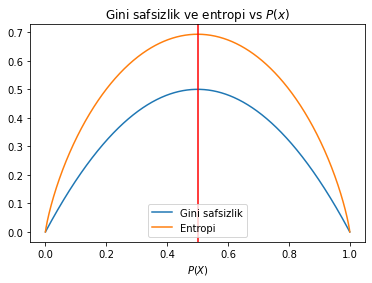

In [7]:
plt.plot(p, gini_impurity(p), label='Gini safsizlik')
plt.plot(p, entropy(p), label='Entropi')
plt.axvline(0.5, color='r')
plt.xlabel('$P(X)$')
plt.legend()
_ = plt.title('Gini safsizlik ve entropi vs $P(x)$')

In [8]:
xx, yy = np.meshgrid(p, p)
zz = np.ones_like(xx) - xx - yy

C:\Users\berk_\AppData\Local\Temp/ipykernel_68392/1090677955.py:1: RuntimeWarning: divide by zero encountered in log
  plt.contourf(xx, yy, -(xx*np.log(xx) + yy * np.log(yy) + zz * np.log(zz)), levels=100)
C:\Users\berk_\AppData\Local\Temp/ipykernel_68392/1090677955.py:1: RuntimeWarning: invalid value encountered in log
  plt.contourf(xx, yy, -(xx*np.log(xx) + yy * np.log(yy) + zz * np.log(zz)), levels=100)
C:\Users\berk_\AppData\Local\Temp/ipykernel_68392/1090677955.py:1: RuntimeWarning: invalid value encountered in multiply
  plt.contourf(xx, yy, -(xx*np.log(xx) + yy * np.log(yy) + zz * np.log(zz)), levels=100)


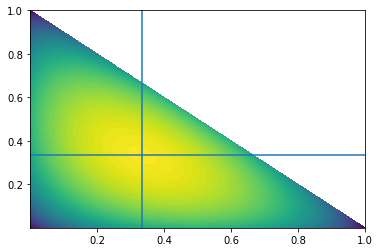

In [9]:
plt.contourf(xx, yy, -(xx*np.log(xx) + yy * np.log(yy) + zz * np.log(zz)), levels=100)
plt.axhline(1/3)
plt.axvline(1/3)

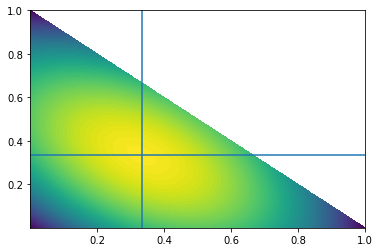

In [10]:
gg = 1 - xx**2 - yy**2 - zz**2
gg[(xx + yy) >= 1] = np.nan
plt.contourf(xx, yy, gg, levels=100)
plt.axhline(1/3)
plt.axvline(1/3)

Gini Impurity and Entropy follow a quite similar trend and very much likely to produce similar results.

#### 1.a.III Implementation of Entropy and Gini Impurity on a single branch

A synthetic dataset is created to demonstrate how Gini Impurity can determine the best split for a categorical variable

In [11]:
np.random.seed(42)
df = pd.DataFrame({'Age': np.random.randint(18, 55, size=12)})
prob_visited = 1 /(1 + np.exp(-(df['Age'] * 0.08 - 2.9)))
df['Purchased'] = prob_visited.apply(lambda x: np.random.choice([0, 1], p=[1 - x, x]))
df = df.sort_values('Age')

Example Scenario:

>A retailer has the following dataset and wants to know which Age group is more likely to make purchases at store. Create a single decision stump using the table below.

>A sample decision stump can be built as follows:  
*if Age > 23 then Purchased = 1  
else Purchased = 0*

In [12]:
df

,Age,Purchased
11,20,0
2,25,1
6,28,0
7,28,0
1,32,1
4,36,0
3,38,0
5,40,0
8,41,1
10,41,1


In [13]:
def gini_df(column: pd.Series) -> float:
    """Calculate impurity of a series consisting of categorical variable."""
    freqs = column.value_counts(True)
    return 1 - (freqs**2).sum()

In [14]:
print('Current Gini impurity for Purchased without splitting:', gini_df(df['Purchased']).round(4))

Current Gini impurity for Purchased without splitting: 0.4861


At current level, Gini Impurity is quite high. We should find a boundary for Age to split dataset, such that splitted datasets have lower impurity than the current one.

We are searching for an Age to split dataset into two parts. Such a value should minimize gini impurity on both sides. To compensate for unequal sizes of splitted datasets, we can rely on **weighted gini impurity**, which weights gini impurity by the sample size of splits.

In [15]:
def split(df: pd.DataFrame, dependent: str, independent: str, boundary: float, eval_func: callable):
    boundary_cond = df[independent] <= boundary  # Bool series
    left = df[boundary_cond]
    right = df[~boundary_cond]
    total_impurity = eval_func(left[dependent]) * left.shape[0] + eval_func(right[dependent]) * right.shape[0]
    weighted_impurity = total_impurity / df.shape[0]
    
    return left, right, weighted_impurity

In [16]:
display()

In [17]:
@interact
def best_split(value=(df['Age'].min()-1, df['Age'].max(), 1)):
    initial_impurity = gini_df(df['Purchased'])
    left, right, impurity = split(df, 'Purchased', 'Age', value, eval_func=gini_df)
    display(left.style.applymap(lambda x: "background-color:" + ("crimson" if x == 0 else "lightgreen"), subset='Purchased')
        .set_caption(f"Left: Age <= {value}").hide_index())
    display(
        right.style.applymap(lambda x: "background-color:" + ("crimson" if x == 0 else "lightgreen"), subset='Purchased')
        .set_caption(f"Right: Age > {value}").hide_index())
    diff = (initial_impurity - impurity).round(4)
    color = 'red' if diff <= 0 else 'green'
    display(Markdown(f"""|Initial Impurity|New Weighted Impurity|Gain\n|---|---|---|\n|{initial_impurity.round(4)}|{impurity.round(4)}|<font color="{color}">{diff.round(4)}</font>"""))
    

interactive(children=(IntSlider(value=36, description='value', max=53, min=19), Output()), _dom_classes=('widg…

In [18]:
from sklearn import tree
agac = tree.DecisionTreeClassifier(max_depth=1)
agac.fit(df[['Age']], df['Purchased'])

DecisionTreeClassifier(max_depth=1)

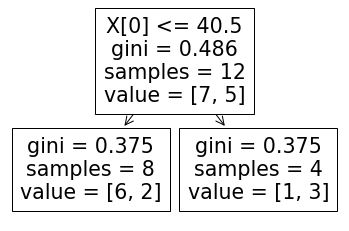

In [19]:
tree.plot_tree(agac);

### 1.b Regression

In [20]:
np.random.seed(42)
df = pd.DataFrame({'Age': np.random.randint(18, 55, size=12)})
formula_time_spent = lambda age: age * (-0.18 if age <= 35 else 0.7) + 29.9
df['Time spent'] = df['Age'].apply(formula_time_spent)
df.loc[12] = [52, 22]
df = df.sort_values('Age')

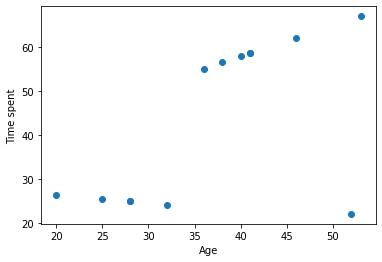

In [21]:
plt.scatter(df['Age'], df['Time spent'])
plt.xlabel('Age')
plt.ylabel('Time spent');

#### 1.b.I Minimum Variance

In [22]:
@interact
def best_split(value=(df['Age'].min()-1, df['Age'].max(), 1)):
    initial_variance = np.var(df['Time spent'])
    left, right, variance = split(df, 'Time spent', 'Age', value, eval_func=np.var)
    display(left.style.background_gradient(cmap='jet', subset=['Time spent'], vmin=25, vmax=70).set_caption(f"Left: Age <= {value}").hide_index())
    display(
        right.style.background_gradient(cmap='jet', subset=['Time spent'], vmin=25, vmax=70)
        .set_caption(f"Right: Age > {value}").hide_index())
    diff = (initial_variance - variance)
    color = 'red' if diff <= 0 else 'green'
    display(Markdown(f"""|Initial Impurity|New Weighted Impurity|Gain\n|---|---|---|\n|{initial_variance: .4f}|{variance: .4f}|<font color="{color}">{diff: .4f}</font>"""))
    

interactive(children=(IntSlider(value=36, description='value', max=53, min=19), Output()), _dom_classes=('widg…